## Pré-processamento

Na fase de criação do dataset uma parte do pré-processamento já foi feita, foi o passo de transformar todas as letras em minúsculas. Na fase atual, inicialmente, tivemos a ideia de remover as stopwords que englobam conectivos como conjunções (e, como, ou, ...). Caso fossem removidas os versos poderiam ficar sem muito significado. 

Referências: 
 - https://keras.io/examples/lstm_text_generation/
 - https://towardsdatascience.com/ai-generates-taylor-swifts-song-lyrics-6fd92a03ef7e

In [1]:
# Bibliotecas utilizadas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from keras.models import Sequential
from keras.layers import LSTM, Activation, Flatten, Dropout, Dense, Embedding, TimeDistributed, GRU
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
import re

%matplotlib inline

Using TensorFlow backend.


In [2]:
# Importação dos dados
dataset = pd.read_csv('musics.csv', encoding = "utf-8")
dataset

,artist,music,track
0,Djavan,"valei-me, deus!\né o fim do nosso amor\nperdoa...",Flor de Lis
1,Gilberto Gil,"aiaiá, kiriê \nkiriê, iaiá \n\na refavela \nre...",Refavela
2,Caetano Veloso,eu sou o vento que lança a areia do saara\nsob...,Reconvexo - Ao Vivo
3,Cássia Eller,é uma índia com colar\na tarde linda que não q...,Relicário - Ao Vivo
4,Elis Regina,não quero lhe falar meu grande amor \ndas cois...,Como Nossos Pais
5,Geraldo Azevedo,se você vier pro que der e vier comigo\neu lhe...,Dia Branco - Ao Vivo | Bonus Track
6,Adriana Calcanhotto,rasgue as minhas cartas\ne não me procure mais...,Devolva-Me (Ao Vivo)
7,João Gilberto,vai minha tristeza e diz a ela que\nsem ela nã...,Chega de Saudade
8,Chico Buarque,"não se afobe, não\nque nada é pra já \no amor ...",Futuros Amantes
9,Ney Matogrosso,tudo de bom que você me fizer\nfaz minha rima ...,Sorte


## Wordcloud

Visualização das palavras que mais se repetem do dataset importado. É claro que conjunções e pronomes são mais utilizados, talvez até poluam o dataset, mas sem estas palavras o sentido dos versos/frases estará comprometido e por isso não serão removidas.

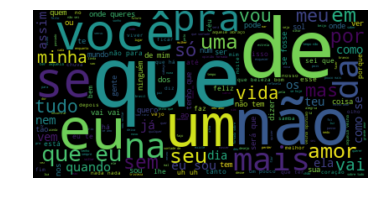

In [3]:
musics = ''.join(dataset['music'])
wordcloud = WordCloud(max_font_size=100, max_words=200, background_color="black").generate(musics)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Vetorização dos textos


Referências:
- https://stackabuse.com/python-for-nlp-deep-learning-text-generation-with-keras/

Mapeando caracteres para char e chars para caracteres.


In [4]:
chars = sorted(list(set(musics)))
int_chars = dict((i, c) for i, c in enumerate(chars))
chars_int = dict((i, c) for c, i in enumerate(chars))

In [5]:
n_chars = len(musics)
n_vocab = len(chars)

In [6]:
seq_len = 100
data_X = []
data_y = []
for i in range(0, n_chars - seq_len, 1):
    seq_in  = musics[i:i+seq_len]
    seq_out = musics[i + seq_len]
    data_X.append([chars_int[char] for char in seq_in])
    data_y.append(chars_int[seq_out])
n_patterns = len(data_X)

In [7]:
X = np.reshape(data_X, (n_patterns, seq_len, 1))
X = X/float(n_vocab)
#Hot encode
y = np_utils.to_categorical(data_y)

In [8]:
# Building model
LSTM_layer_num = 4;
layer_size = [256, 256, 256, 256]

model = Sequential()
model.add(GRU(layer_size[0], input_shape=(X.shape[1], X.shape[2]), return_sequences=True))

for i in range(1, LSTM_layer_num):
    model.add(GRU(layer_size[i], return_sequences=True))

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
model.add(Flatten())
model.add(Dense(y.shape[1]))
model.add(Activation('softmax'))
model.compile(loss= 'categorical_crossentropy', optimizer = 'adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 100, 256)          198144    
_________________________________________________________________
gru_2 (GRU)                  (None, 100, 256)          393984    
_________________________________________________________________
gru_3 (GRU)                  (None, 100, 256)          393984    
_________________________________________________________________
gru_4 (GRU)                  (None, 100, 256)          393984    
_________________________________________________________________
flatten_1 (Flatten)          (None, 25600)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 63)                1612863   
_________________________________________________________________
activation_1 (Activation)    (None, 63)                0         
Total para

In [10]:
checkpoint_name = 'Weights-GRU-improvement-{epoch:03d}-{loss:.5f}-bigger.hdf5'
checkpoint = ModelCheckpoint(checkpoint_name, monitor='loss', verbose=1, save_best_only = True, mode = 'min')
callbacks_list = [checkpoint]

In [11]:
# Training

model_params = {
    'epochs': 1,
    'batch_size': 128,
    'callbacks': callbacks_list,
    'verbose': 1,
    'validation_split': 0.8,
    'validation_data': None,
    'shuffle': True,
    'initial_epoch': 0,
    'steps_per_epoch': None,
    'validation_steps': None
    }

model.fit(X, 
          y,
          epochs = model_params['epochs'],
          batch_size= model_params['batch_size'],
          callbacks = model_params['callbacks'],
          verbose = model_params['verbose'],
          validation_split = model_params['validation_split'],
          validation_data = model_params['validation_data'],
          shuffle = model_params['shuffle'],
          initial_epoch = model_params['initial_epoch'],
          steps_per_epoch = model_params['steps_per_epoch'],
          validation_steps = model_params['validation_steps']
            )

Instructions for updating:
Use tf.cast instead.
Train on 9747 samples, validate on 38993 samples
Epoch 1/1
9747/9747 [==============================] - 873s 90ms/step - loss: 3.0821 - val_loss: 3.0264

Epoch 00001: loss improved from inf to 3.08211, saving model to Weights-GRU-improvement-001-3.08211-bigger.hdf5


In [13]:
# Load wights file :
wights_file = 'Weights-GRU-improvement-001-3.08211-bigger.hdf5' # weights file path
model.load_weights(wights_file)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

In [23]:
# set a random seed :
start = np.random.randint(0, len(data_X)-1)
pattern = data_X[start]
print('Seed : ')
print("\"",''.join([int_chars[value] for value in pattern]), "\"\n")
generated_characters = 300
for i in range(generated_characters):
    x = np.reshape(pattern, ( 1, len(pattern), 1))
    x = x / float(n_vocab)
    arquivo = ('letra.txt','w')
    prediction = model.predict(x,verbose = 0)
    index = np.argmax(prediction)
    result = int_chars[index]
    sys.stdout.write(result)

    pattern.append(index)
    pattern = pattern[1:len(pattern)]
print('\nDone')

Seed : 
"  ser melhor meu bem

o retrato que eu te dei
se ainda tens não sei
mas se tiver devolva-me

o retrat "



FileNotFoundError: [Errno 2] No such file or directory: 'letra.txt'